# Radioactive Decay Chain (of many isotopes) Modeling with PINNs

## Load packages and set seed

In [39]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

seed = 42

## Simulate data

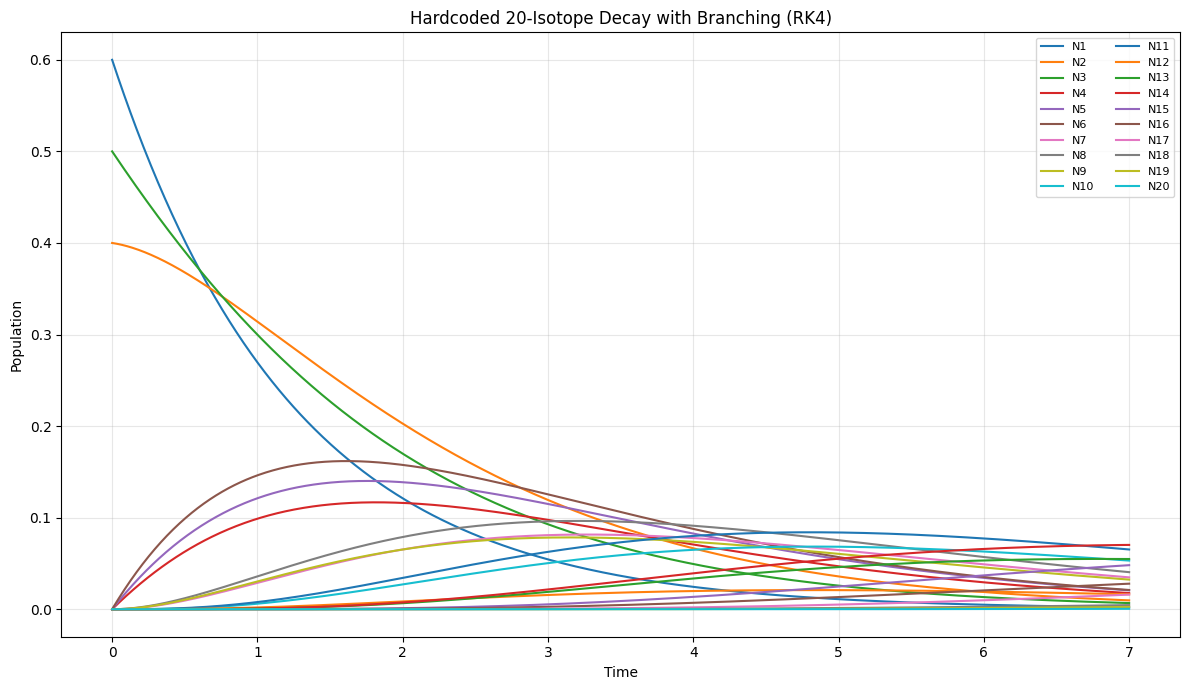

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Time grid
# -----------------------------
t_start = 0.0
t_end = 7.0
num_steps = 1000
t = np.linspace(t_start, t_end, num_steps)
dt = t[1] - t[0]

# -----------------------------
# Decay constants (1..20)
# last one is stable
# -----------------------------
lam1  = 0.80
lam2  = 0.78
lam3  = 0.76
lam4  = 0.74
lam5  = 0.72
lam6  = 0.70
lam7  = 0.68
lam8  = 0.66
lam9  = 0.64
lam10 = 0.62
lam11 = 0.60
lam12 = 0.58
lam13 = 0.46
lam14 = 0.34
lam15 = 0.26
lam16 = 0.18
lam17 = 0.14
lam18 = 0.10
lam19 = 0.06
lam20 = 0.00  # stable

# -----------------------------
# Initial conditions
# -----------------------------
N0 = np.zeros(20, dtype=float)
N0[0], N0[1], N0[2] = 0.6, 0.4, 0.5  # N1, N2, N3
N = np.zeros((num_steps, 20), dtype=float)
N[0] = N0

# -----------------------------
# Explicit RHS (no matrices)
# Branching scheme:
# 1→2 (0.60), 3 (0.30)
# 2→4 (0.50), 5 (0.40)
# 3→5 (0.20), 6 (0.70)
# 4→7 (0.60)
# 5→7 (0.20), 8 (0.50)
# 6→8 (0.30), 9 (0.60)
# 7→10 (0.70)
# 8→10 (0.20), 11 (0.50)
# 9→11 (0.60), 12 (0.30)
# 10→13 (0.50)
# 11→13 (0.20), 14 (0.50)
# 12→14 (0.60)
# 13→15 (0.70)
# 14→15 (0.20), 16 (0.50)
# 15→17 (0.60)
# 16→17 (0.30), 18 (0.50)
# 17→19 (0.70)
# 18→19 (0.40), 20 (0.50)
# 19→20 (0.80)
# 20 stable
# -----------------------------
def rhs(Nv):
    N1, N2, N3, N4, N5, N6, N7, N8, N9, N10, \
    N11, N12, N13, N14, N15, N16, N17, N18, N19, N20 = Nv

    dN1  = -lam1  * N1
    dN2  = -lam2  * N2  + lam1 * 0.60 * N1
    dN3  = -lam3  * N3  + lam1 * 0.30 * N1
    dN4  = -lam4  * N4  + lam2 * 0.50 * N2
    dN5  = -lam5  * N5  + lam2 * 0.40 * N2 + lam3 * 0.20 * N3
    dN6  = -lam6  * N6  + lam3 * 0.70 * N3
    dN7  = -lam7  * N7  + lam4 * 0.60 * N4 + lam5 * 0.20 * N5
    dN8  = -lam8  * N8  + lam5 * 0.50 * N5 + lam6 * 0.30 * N6
    dN9  = -lam9  * N9  + lam6 * 0.60 * N6
    dN10 = -lam10 * N10 + lam7 * 0.70 * N7 + lam8 * 0.20 * N8
    dN11 = -lam11 * N11 + lam8 * 0.50 * N8 + lam9 * 0.60 * N9
    dN12 = -lam12 * N12 + lam9 * 0.30 * N9
    dN13 = -lam13 * N13 + lam10 * 0.50 * N10 + lam11 * 0.20 * N11
    dN14 = -lam14 * N14 + lam11 * 0.50 * N11 + lam12 * 0.60 * N12
    dN15 = -lam15 * N15 + lam13 * 0.70 * N13 + lam14 * 0.20 * N14
    dN16 = -lam16 * N16 + lam14 * 0.50 * N14
    dN17 = -lam17 * N17 + lam15 * 0.60 * N15 + lam16 * 0.30 * N16
    dN18 = -lam18 * N18 + lam16 * 0.50 * N16
    dN19 = -lam19 * N19 + lam17 * 0.70 * N17 + lam18 * 0.40 * N18
    dN20 = -lam20 * N20 + lam18 * 0.50 * N18 + lam19 * 0.80 * N19

    return np.array([dN1, dN2, dN3, dN4, dN5, dN6, dN7, dN8, dN9, dN10,
                     dN11, dN12, dN13, dN14, dN15, dN16, dN17, dN18, dN19, dN20],
                    dtype=float)

# -----------------------------
# RK4 integration
# -----------------------------
for k in range(1, num_steps):
    y = N[k-1]
    k1 = rhs(y)
    k2 = rhs(y + 0.5 * dt * k1)
    k3 = rhs(y + 0.5 * dt * k2)
    k4 = rhs(y + dt * k3)
    N[k] = y + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# Clean up tiny negatives
N = np.clip(N, 0.0, None)

# --- NOW build tensors for training/eval ---
t_tensor = torch.tensor(t, dtype=torch.float32).view(-1, 1)

# simplest: use N directly (no manual stacking mistakes)
N_data = torch.tensor(N, dtype=torch.float32)    # shape [T, 20]

# Collocation points
n_collocation = 4
rng = np.random.default_rng(0)  # optional: reproducible
indices = np.sort(rng.choice(len(t), n_collocation, replace=False))
t_col = torch.tensor(t[indices], dtype=torch.float32).view(-1, 1).requires_grad_(True)
N_col = N_data[indices]

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(12, 7))
for j in range(20):
    plt.plot(t, N[:, j], label=f'N{j+1}')
plt.title("Hardcoded 20-Isotope Decay with Branching (RK4)")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend(ncol=2, fontsize=8, frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Define ANN

In [47]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 8), nn.Tanh(),
            nn.Linear(8, 8), nn.Tanh(),
            nn.Linear(8, 20)
        )

    def forward(self, t):
        return self.net(t)

def compute_derivatives(y, t):
    dy = grad(y, t, torch.ones_like(y), create_graph=True)[0]
    return dy

## Direct solution model

In [60]:
# hyperparameters:
lr = 1e-3
epochs = 20000

In [61]:
torch.manual_seed(seed)
model_direct = MLP()
optimizer = torch.optim.Adam(model_direct.parameters(), lr=lr)

# Only use collocation points for training
t_col_supervised = t_tensor[indices]  # detached input without gradients
N_col_supervised = N_data[indices]

for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model_direct(t_col_supervised)
    loss = ((pred - N_col_supervised)**2).mean()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"[Direct ANN - Collocation Only] Epoch {epoch}: Loss = {loss.item():.6f}")
pred_direct = model_direct(t_tensor).detach().numpy()

[Direct ANN - Collocation Only] Epoch 0: Loss = 0.092512
[Direct ANN - Collocation Only] Epoch 1000: Loss = 0.000636
[Direct ANN - Collocation Only] Epoch 2000: Loss = 0.000131
[Direct ANN - Collocation Only] Epoch 3000: Loss = 0.000050
[Direct ANN - Collocation Only] Epoch 4000: Loss = 0.000041
[Direct ANN - Collocation Only] Epoch 5000: Loss = 0.000035
[Direct ANN - Collocation Only] Epoch 6000: Loss = 0.000028
[Direct ANN - Collocation Only] Epoch 7000: Loss = 0.000021
[Direct ANN - Collocation Only] Epoch 8000: Loss = 0.000015
[Direct ANN - Collocation Only] Epoch 9000: Loss = 0.000009
[Direct ANN - Collocation Only] Epoch 10000: Loss = 0.000004
[Direct ANN - Collocation Only] Epoch 11000: Loss = 0.000002
[Direct ANN - Collocation Only] Epoch 12000: Loss = 0.000001
[Direct ANN - Collocation Only] Epoch 13000: Loss = 0.000001
[Direct ANN - Collocation Only] Epoch 14000: Loss = 0.000000
[Direct ANN - Collocation Only] Epoch 15000: Loss = 0.000000
[Direct ANN - Collocation Only] Epoch

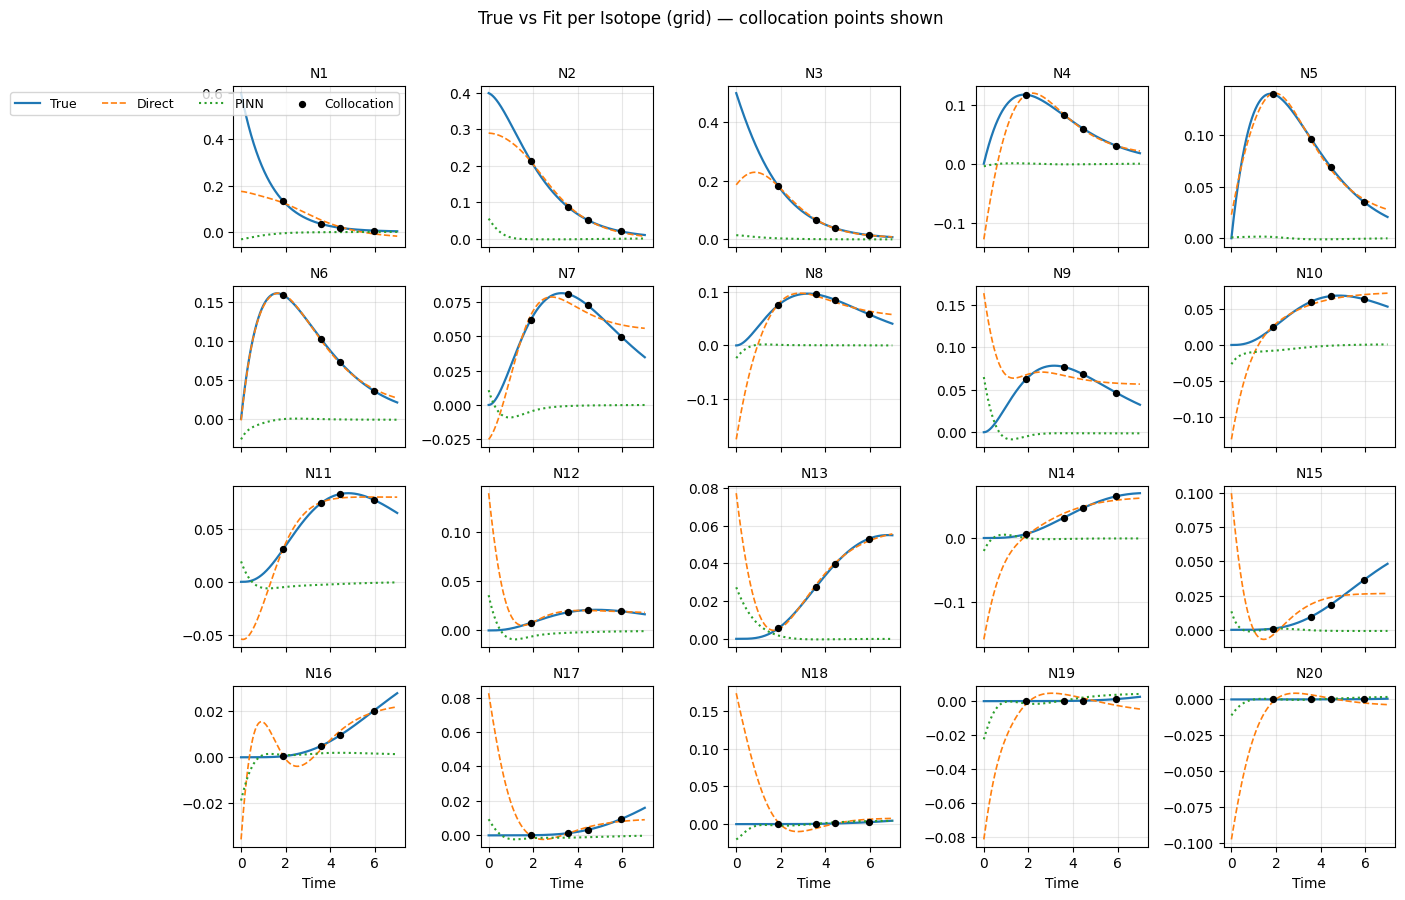

In [62]:
# --- consistency + conversions
T = len(t)
assert N_data.shape == (T, 20), f"N_data shape {tuple(N_data.shape)} != ({T}, 20)"
assert pred_direct_all.shape == (T, 20), f"pred_direct_all shape {tuple(pred_direct_all.shape)} != ({T}, 20)"
# pred_pinn_all is optional; if you don't have it, the code will skip that layer
has_pinn = 'pred_pinn_all' in globals() and pred_pinn_all.shape == (T, 20)

t_np    = np.asarray(t).reshape(-1)
true_np = N_data.detach().cpu().numpy() if isinstance(N_data, torch.Tensor) else np.asarray(N_data)
pdir_np = pred_direct_all.detach().cpu().numpy() if isinstance(pred_direct_all, torch.Tensor) else np.asarray(pred_direct_all)
ppin_np = pred_pinn_all.detach().cpu().numpy() if has_pinn and isinstance(pred_pinn_all, torch.Tensor) else (pred_pinn_all if has_pinn else None)

# --- plot grid: 4 rows x 5 cols
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(14, 9), sharex=True)
axes = axes.ravel()

for j, ax in enumerate(axes):
    ax.plot(t_np, true_np[:, j], '-',  lw=1.6, label='True')
    ax.plot(t_np, pdir_np[:, j], '--', lw=1.2, label='Direct')
    if has_pinn:
        ax.plot(t_np, ppin_np[:, j], ':', lw=1.5, label='PINN')
    # collocation points for this isotope (true values)
    ax.scatter(t_np[indices], true_np[indices, j], c='k', s=18, zorder=5, label=('Collocation' if j == 0 else None))
    ax.grid(True, alpha=0.3)
    ax.set_title(f"N{j+1}", fontsize=10)

# shared labels / legend
for ax in axes[15:]:
    ax.set_xlabel("Time")
axes[0].legend(ncol=4 if has_pinn else 3, fontsize=9, frameon=True, loc='upper right')

fig.suptitle("True vs Fit per Isotope (grid) — collocation points shown", y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.985])
plt.show()


## PINN

In [68]:
# hyperparameters:
lr = 1e-3
epochs = 20000

In [71]:
torch.manual_seed(seed)
model_pinn = MLP()
optimizer = torch.optim.Adam(model_pinn.parameters(), lr=lr)

# ---- Decay constants (torch tensors) ----
lam1  = torch.tensor(0.80, dtype=torch.float32)
lam2  = torch.tensor(0.78, dtype=torch.float32)
lam3  = torch.tensor(0.76, dtype=torch.float32)
lam4  = torch.tensor(0.74, dtype=torch.float32)
lam5  = torch.tensor(0.72, dtype=torch.float32)
lam6  = torch.tensor(0.70, dtype=torch.float32)
lam7  = torch.tensor(0.68, dtype=torch.float32)
lam8  = torch.tensor(0.66, dtype=torch.float32)
lam9  = torch.tensor(0.64, dtype=torch.float32)
lam10 = torch.tensor(0.62, dtype=torch.float32)
lam11 = torch.tensor(0.60, dtype=torch.float32)
lam12 = torch.tensor(0.58, dtype=torch.float32)
lam13 = torch.tensor(0.46, dtype=torch.float32)
lam14 = torch.tensor(0.34, dtype=torch.float32)
lam15 = torch.tensor(0.26, dtype=torch.float32)
lam16 = torch.tensor(0.18, dtype=torch.float32)
lam17 = torch.tensor(0.14, dtype=torch.float32)
lam18 = torch.tensor(0.10, dtype=torch.float32)
lam19 = torch.tensor(0.06, dtype=torch.float32)
lam20 = torch.tensor(0.00, dtype=torch.float32)  # stable

for epoch in range(epochs):
    optimizer.zero_grad()

    # ---------------- Residuals on collocation points ----------------
    # (assumes you already created t_col with requires_grad_(True))
    pred_col = model_pinn(t_col)  # [m, 20]

    N1,N2,N3,N4,N5,N6,N7,N8,N9,N10, \
    N11,N12,N13,N14,N15,N16,N17,N18,N19,N20 = [pred_col[:,i:i+1] for i in range(20)]

    dN1  = compute_derivatives(N1,  t_col)
    dN2  = compute_derivatives(N2,  t_col)
    dN3  = compute_derivatives(N3,  t_col)
    dN4  = compute_derivatives(N4,  t_col)
    dN5  = compute_derivatives(N5,  t_col)
    dN6  = compute_derivatives(N6,  t_col)
    dN7  = compute_derivatives(N7,  t_col)
    dN8  = compute_derivatives(N8,  t_col)
    dN9  = compute_derivatives(N9,  t_col)
    dN10 = compute_derivatives(N10, t_col)
    dN11 = compute_derivatives(N11, t_col)
    dN12 = compute_derivatives(N12, t_col)
    dN13 = compute_derivatives(N13, t_col)
    dN14 = compute_derivatives(N14, t_col)
    dN15 = compute_derivatives(N15, t_col)
    dN16 = compute_derivatives(N16, t_col)
    dN17 = compute_derivatives(N17, t_col)
    dN18 = compute_derivatives(N18, t_col)
    dN19 = compute_derivatives(N19, t_col)
    dN20 = compute_derivatives(N20, t_col)

    # RHS (hardcoded, matches simulator’s branching)
    # dNi/dt = -lami*Ni + sum(parents -> i)
    # residual = dNi - RHS = 0  =>  dNi + lami*Ni - sum(parents contributions) = 0

    res1  = dN1  + lam1  * N1
    res2  = dN2  + lam2  * N2  - lam1  * 0.60 * N1
    res3  = dN3  + lam3  * N3  - lam1  * 0.30 * N1
    res4  = dN4  + lam4  * N4  - lam2  * 0.50 * N2
    res5  = dN5  + lam5  * N5  - (lam2 * 0.40 * N2 + lam3 * 0.20 * N3)
    res6  = dN6  + lam6  * N6  - lam3  * 0.70 * N3
    res7  = dN7  + lam7  * N7  - (lam4 * 0.60 * N4 + lam5 * 0.20 * N5)
    res8  = dN8  + lam8  * N8  - (lam5 * 0.50 * N5 + lam6 * 0.30 * N6)
    res9  = dN9  + lam9  * N9  - (lam6 * 0.60 * N6)
    res10 = dN10 + lam10 * N10 - (lam7 * 0.70 * N7 + lam8 * 0.20 * N8)
    res11 = dN11 + lam11 * N11 - (lam8 * 0.50 * N8 + lam9 * 0.60 * N9)
    res12 = dN12 + lam12 * N12 - (lam9 * 0.30 * N9)
    res13 = dN13 + lam13 * N13 - (lam10* 0.50 * N10 + lam11 * 0.20 * N11)
    res14 = dN14 + lam14 * N14 - (lam11* 0.50 * N11 + lam12 * 0.60 * N12)
    res15 = dN15 + lam15 * N15 - (lam13* 0.70 * N13 + lam14 * 0.20 * N14)
    res16 = dN16 + lam16 * N16 - (lam14* 0.50 * N14)
    res17 = dN17 + lam17 * N17 - (lam15* 0.60 * N15 + lam16 * 0.30 * N16)
    res18 = dN18 + lam18 * N18 - (lam16* 0.50 * N16)
    res19 = dN19 + lam19 * N19 - (lam17* 0.70 * N17 + lam18 * 0.40 * N18)
    res20 = dN20 + lam20 * N20 - (lam18* 0.50 * N18 + lam19 * 0.80 * N19)

    loss_ode = sum(r.pow(2).mean() for r in
                   [res1,res2,res3,res4,res5,res6,res7,res8,res9,
                    res10,res11,res12,res13,res14,res15,res16,res17,res18,res19,res20])

    # ---------------- Supervised fit on all time points ----------------
    pred_all = model_pinn(t_tensor)     # [T, 20]
    loss_data = ((pred_all - N_data)**2).mean()

    # ---------------- Total loss ----------------
    loss = loss_ode + loss_data
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"[PINN] Epoch {epoch}: Loss = {loss.item():.6f}, Loss ODE: {loss_ode:.6f}, Loss Data: {loss_data:.6f}.")

with torch.no_grad():
    pred_pinn = model_pinn(t_tensor).cpu().numpy()  # [T, 20]

[PINN] Epoch 0: Loss = 0.665476, Loss ODE: 0.569065, Loss Data: 0.096411.
[PINN] Epoch 1000: Loss = 0.002495, Loss ODE: 0.000779, Loss Data: 0.001716.
[PINN] Epoch 2000: Loss = 0.000479, Loss ODE: 0.000279, Loss Data: 0.000200.
[PINN] Epoch 3000: Loss = 0.000224, Loss ODE: 0.000147, Loss Data: 0.000077.
[PINN] Epoch 4000: Loss = 0.000125, Loss ODE: 0.000080, Loss Data: 0.000045.
[PINN] Epoch 5000: Loss = 0.000064, Loss ODE: 0.000034, Loss Data: 0.000030.
[PINN] Epoch 6000: Loss = 0.000033, Loss ODE: 0.000014, Loss Data: 0.000020.
[PINN] Epoch 7000: Loss = 0.000023, Loss ODE: 0.000009, Loss Data: 0.000014.
[PINN] Epoch 8000: Loss = 0.000019, Loss ODE: 0.000008, Loss Data: 0.000011.
[PINN] Epoch 9000: Loss = 0.000018, Loss ODE: 0.000008, Loss Data: 0.000010.
[PINN] Epoch 10000: Loss = 0.000012, Loss ODE: 0.000005, Loss Data: 0.000007.
[PINN] Epoch 11000: Loss = 0.000009, Loss ODE: 0.000004, Loss Data: 0.000005.
[PINN] Epoch 12000: Loss = 0.000010, Loss ODE: 0.000006, Loss Data: 0.000004.

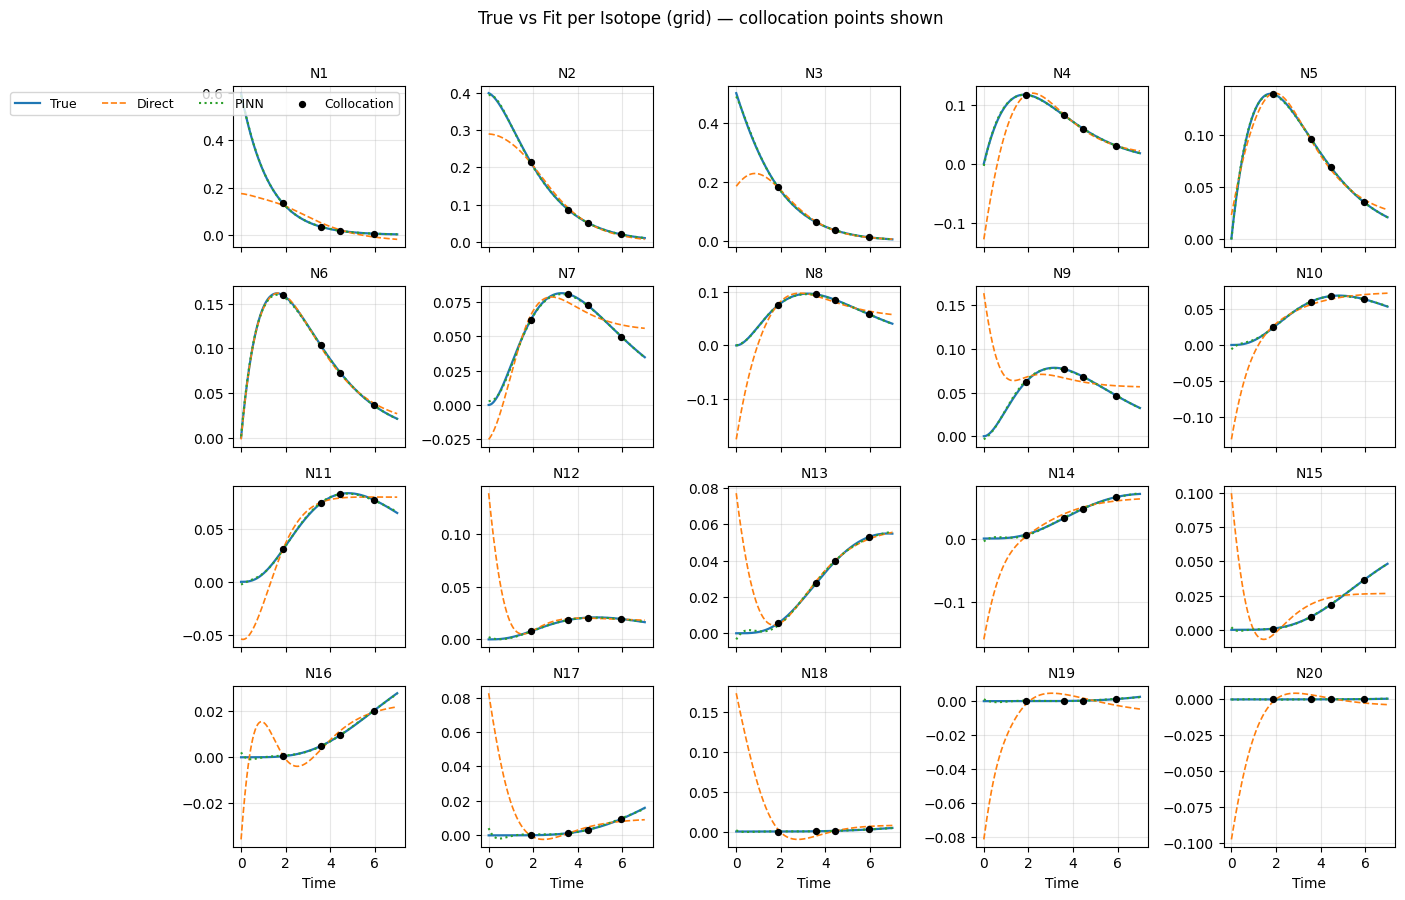

In [74]:
# --- consistency + conversions
T = len(t)
assert N_data.shape == (T, 20), f"N_data shape {tuple(N_data.shape)} != ({T}, 20)"
assert pred_direct_all.shape == (T, 20), f"pred_direct_all shape {tuple(pred_direct_all.shape)} != ({T}, 20)"

pred_pinn_all = torch.as_tensor(pred_pinn, dtype=torch.float32)       # [T,20]
# pred_pinn_all is optional; if you don't have it, the code will skip that layer
has_pinn = 'pred_pinn_all' in globals() and pred_pinn_all.shape == (T, 20)

t_np    = np.asarray(t).reshape(-1)
true_np = N_data.detach().cpu().numpy() if isinstance(N_data, torch.Tensor) else np.asarray(N_data)
pdir_np = pred_direct_all.detach().cpu().numpy() if isinstance(pred_direct_all, torch.Tensor) else np.asarray(pred_direct_all)
ppin_np = pred_pinn_all.detach().cpu().numpy() if has_pinn and isinstance(pred_pinn_all, torch.Tensor) else (pred_pinn_all if has_pinn else None)

# --- plot grid: 4 rows x 5 cols
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(14, 9), sharex=True)
axes = axes.ravel()

for j, ax in enumerate(axes):
    ax.plot(t_np, true_np[:, j], '-',  lw=1.6, label='True')
    ax.plot(t_np, pdir_np[:, j], '--', lw=1.2, label='Direct')
    if has_pinn:
        ax.plot(t_np, ppin_np[:, j], ':', lw=1.5, label='PINN')
    # collocation points for this isotope (true values)
    ax.scatter(t_np[indices], true_np[indices, j], c='k', s=18, zorder=5, label=('Collocation' if j == 0 else None))
    ax.grid(True, alpha=0.3)
    ax.set_title(f"N{j+1}", fontsize=10)

# shared labels / legend
for ax in axes[15:]:
    ax.set_xlabel("Time")
axes[0].legend(ncol=4 if has_pinn else 3, fontsize=9, frameon=True, loc='upper right')

fig.suptitle("True vs Fit per Isotope (grid) — collocation points shown", y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.985])
plt.savefig("true-vs-fit_radioactive-decay.png", dpi=300)
plt.show()


## Evaluate model and predict time series

In [35]:
# ---------------- Direct model losses ----------------
pred_direct_all = torch.as_tensor(pred_direct, dtype=torch.float32)   # [T,20]
L_direct_mse   = ((pred_direct_all - N_data)**2).mean().item()
L_direct_total = L_direct_mse  # only data term for the direct model

# ---------------- PINN data loss ----------------
pred_pinn_all = torch.as_tensor(pred_pinn, dtype=torch.float32)       # [T,20]
L_pinn_mse    = ((pred_pinn_all - N_data)**2).mean().item()

# ---------------- PINN ODE residual loss on collocation ----------------
pred_col = model_pinn(t_col)  # [m,20]
N1,N2,N3,N4,N5,N6,N7,N8,N9,N10, \
N11,N12,N13,N14,N15,N16,N17,N18,N19,N20 = [pred_col[:,i:i+1] for i in range(20)]

dN1  = compute_derivatives(N1,  t_col)
dN2  = compute_derivatives(N2,  t_col)
dN3  = compute_derivatives(N3,  t_col)
dN4  = compute_derivatives(N4,  t_col)
dN5  = compute_derivatives(N5,  t_col)
dN6  = compute_derivatives(N6,  t_col)
dN7  = compute_derivatives(N7,  t_col)
dN8  = compute_derivatives(N8,  t_col)
dN9  = compute_derivatives(N9,  t_col)
dN10 = compute_derivatives(N10, t_col)
dN11 = compute_derivatives(N11, t_col)
dN12 = compute_derivatives(N12, t_col)
dN13 = compute_derivatives(N13, t_col)
dN14 = compute_derivatives(N14, t_col)
dN15 = compute_derivatives(N15, t_col)
dN16 = compute_derivatives(N16, t_col)
dN17 = compute_derivatives(N17, t_col)
dN18 = compute_derivatives(N18, t_col)
dN19 = compute_derivatives(N19, t_col)
dN20 = compute_derivatives(N20, t_col)

# Decay constants must match those used in training (as torch tensors):
# lam1, lam2, ..., lam20 already defined earlier

# Residuals: dNi + lami*Ni - sum(parent->i fluxes) = 0
res1  = dN1  + lam1  * N1
res2  = dN2  + lam2  * N2  - lam1  * 0.60 * N1
res3  = dN3  + lam3  * N3  - lam1  * 0.30 * N1
res4  = dN4  + lam4  * N4  - lam2  * 0.50 * N2
res5  = dN5  + lam5  * N5  - (lam2 * 0.40 * N2 + lam3 * 0.20 * N3)
res6  = dN6  + lam6  * N6  - lam3  * 0.70 * N3
res7  = dN7  + lam7  * N7  - (lam4 * 0.60 * N4 + lam5 * 0.20 * N5)
res8  = dN8  + lam8  * N8  - (lam5 * 0.50 * N5 + lam6 * 0.30 * N6)
res9  = dN9  + lam9  * N9  - (lam6 * 0.60 * N6)
res10 = dN10 + lam10 * N10 - (lam7 * 0.70 * N7 + lam8 * 0.20 * N8)
res11 = dN11 + lam11 * N11 - (lam8 * 0.50 * N8 + lam9 * 0.60 * N9)
res12 = dN12 + lam12 * N12 - (lam9 * 0.30 * N9)
res13 = dN13 + lam13 * N13 - (lam10* 0.50 * N10 + lam11 * 0.20 * N11)
res14 = dN14 + lam14 * N14 - (lam11* 0.50 * N11 + lam12 * 0.60 * N12)
res15 = dN15 + lam15 * N15 - (lam13* 0.70 * N13 + lam14 * 0.20 * N14)
res16 = dN16 + lam16 * N16 - (lam14* 0.50 * N14)
res17 = dN17 + lam17 * N17 - (lam15* 0.60 * N15 + lam16 * 0.30 * N16)
res18 = dN18 + lam18 * N18 - (lam16* 0.50 * N16)
res19 = dN19 + lam19 * N19 - (lam17* 0.70 * N17 + lam18 * 0.40 * N18)
res20 = dN20 + lam20 * N20 - (lam18* 0.50 * N18 + lam19 * 0.80 * N19)

L_pinn_ode = torch.stack([
    (res1**2).mean(), (res2**2).mean(), (res3**2).mean(), (res4**2).mean(), (res5**2).mean(),
    (res6**2).mean(), (res7**2).mean(), (res8**2).mean(), (res9**2).mean(), (res10**2).mean(),
    (res11**2).mean(),(res12**2).mean(),(res13**2).mean(),(res14**2).mean(),(res15**2).mean(),
    (res16**2).mean(),(res17**2).mean(),(res18**2).mean(),(res19**2).mean(),(res20**2).mean()
]).sum().item()

L_pinn_total = L_pinn_mse + L_pinn_ode

print(f"L_direct_mse  = {L_direct_mse:.6e}")
print(f"L_direct_total= {L_direct_total:.6e}")
print(f"L_pinn_mse    = {L_pinn_mse:.6e}")
print(f"L_pinn_ode    = {L_pinn_ode:.6e}")
print(f"L_pinn_total  = {L_pinn_total:.6e}")

L_direct_mse  = 2.424306e-04
L_direct_total= 2.424306e-04
L_pinn_mse    = 6.891955e-05
L_pinn_ode    = 1.146741e-05
L_pinn_total  = 8.038697e-05


In [37]:
# --- Rebuild N_data from the simulator output N (shape [T, 20]) ---
assert isinstance(N, np.ndarray) and N.ndim == 2 and N.shape[1] == 20, f"N shape is {getattr(N,'shape',None)}; expected [T,20]"
N_true_train = N.copy()  # freeze a clean copy for sanity checks
N_data = torch.from_numpy(N_true_train.astype(np.float32))  # [T,20]
t_tensor = torch.from_numpy(t.astype(np.float32)).view(-1,1)

print("N_data shape:", tuple(N_data.shape))
print("t_tensor shape:", tuple(t_tensor.shape))

# --- Elementwise sanity: non-negativity, finite, reasonable ranges ---
has_nan = torch.isnan(N_data).any().item()
has_inf = torch.isinf(N_data).any().item()
print("N_data has NaN?", has_nan, "has Inf?", has_inf)

mins, _ = torch.min(N_data, dim=0)
maxs, _ = torch.max(N_data, dim=0)
print("Per-isotope min/max (first 10 shown):")
for j in range(10):
    print(f"N{j+1:02d}: [{mins[j].item():.6g}, {maxs[j].item():.6g}]")
print("...")

# --- Total inventory should be non-increasing (due to sink losses) ---
total = N_true_train.sum(axis=1)
total_diff = np.diff(total)
violations = np.sum(total_diff > 1e-9)
print(f"Total inventory start/end: {total[0]:.6g} -> {total[-1]:.6g} | nondecrease steps: {violations}")

# --- Spot-check first few time points for first 3 isotopes ---
print("Head (t, N1..N3):")
for k in range(min(5, len(t))):
    print(f"t={t[k]:.4f} | {N_true_train[k,0]:.6f} {N_true_train[k,1]:.6f} {N_true_train[k,2]:.6f}")


N_data shape: (1000, 20)
t_tensor shape: (1000, 1)
N_data has NaN? False has Inf? False
Per-isotope min/max (first 10 shown):
N01: [0.00221872, 0.6]
N02: [0.00970339, 0.4]
N03: [0.00674798, 0.5]
N04: [0, 0.116759]
N05: [0, 0.140097]
N06: [0, 0.161805]
N07: [0, 0.0815721]
N08: [0, 0.0964607]
N09: [0, 0.0784334]
N10: [0, 0.0684248]
...
Total inventory start/end: 1.5 -> 0.545207 | nondecrease steps: 0
Head (t, N1..N3):
t=0.0000 | 0.600000 0.400000 0.500000
t=0.0070 | 0.596646 0.399827 0.498348
t=0.0140 | 0.593311 0.399643 0.496699
t=0.0210 | 0.589994 0.399449 0.495053
t=0.0280 | 0.586696 0.399245 0.493411


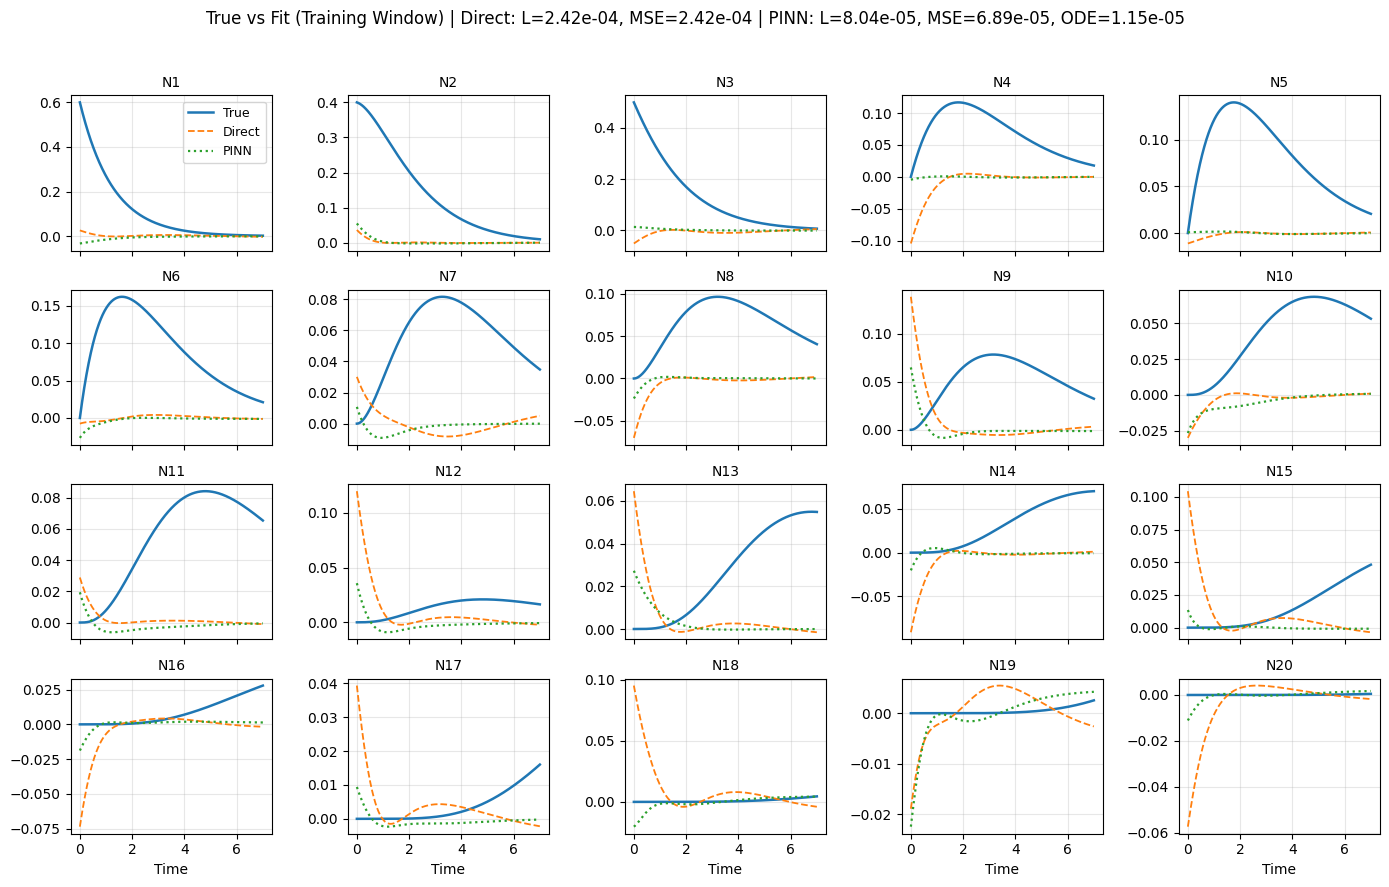

In [38]:
# ==== True vs Fit on training window (no extrapolation) ====
import matplotlib.pyplot as plt

# Use the tensors you already computed above for consistent shapes
T = t.shape[0]
assert pred_direct_all.shape == (T, 20) and pred_pinn_all.shape == (T, 20), "Pred shapes mismatch."
assert N_data.shape == (T, 20), "N_data shape mismatch."

pred_direct_np = pred_direct_all.cpu().numpy()
pred_pinn_np   = pred_pinn_all.cpu().numpy()
true_np        = N_data.cpu().numpy() if hasattr(N_data, "cpu") else N_data.numpy()

fig, axes = plt.subplots(4, 5, figsize=(14, 9), sharex=True)
axes = axes.ravel()

for j in range(20):
    ax = axes[j]
    ax.plot(t, true_np[:, j], '-',  lw=1.8, label='True')
    ax.plot(t, pred_direct_np[:, j], '--', lw=1.3, label='Direct')
    ax.plot(t, pred_pinn_np[:, j],   ':', lw=1.6, label='PINN')
    ax.grid(True, alpha=0.3)
    ax.set_title(f"N{j+1}", fontsize=10)

# Only one legend to avoid clutter
axes[0].legend(fontsize=9, frameon=True)

fig.suptitle(
    f"True vs Fit (Training Window) | "
    f"Direct: L={L_direct_total:.2e}, MSE={L_direct_mse:.2e} | "
    f"PINN: L={L_pinn_total:.2e}, MSE={L_pinn_mse:.2e}, ODE={L_pinn_ode:.2e}",
    fontsize=12
)
for ax in axes[-5:]:
    ax.set_xlabel("Time")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [21]:
prediction_time = 3.

# ---------- Extrapolation time grid ----------
t_extra = np.linspace(t_end, t_end + prediction_time, 200)   # includes t_end
t_extra_tensor = torch.tensor(t_extra, dtype=torch.float32).view(-1, 1)

# ---------- Model extrapolations ----------
with torch.no_grad():
    pred_direct_extra = model_direct(t_extra_tensor).cpu().numpy()  # [Te, 20]
    pred_pinn_extra   = model_pinn(t_extra_tensor).cpu().numpy()    # [Te, 20]

# Concatenate (skip the first extra point to avoid duplicating t_end)
t_total = np.concatenate([t, t_extra[1:]])                           # [T + Te-1]
pred_direct_total = np.vstack([pred_direct, pred_direct_extra[1:]])  # [T + Te-1, 20]
pred_pinn_total   = np.vstack([pred_pinn,   pred_pinn_extra[1:]])    # [T + Te-1, 20]

# ---------- Ground-truth rollout on [t_end, t_end + prediction_time] ----------
dt_extra = t_extra[1] - t_extra[0]
N_extra = np.zeros((len(t_extra), 20), dtype=float)
N_extra[0] = N[-1]  # start from last known state at t_end

# RK4 using your previously defined rhs(Nv)
for k in range(1, len(t_extra)):
    y = N_extra[k-1]
    k1 = rhs(y)
    k2 = rhs(y + 0.5 * dt_extra * k1)
    k3 = rhs(y + 0.5 * dt_extra * k2)
    k4 = rhs(y + dt_extra * k3)
    N_extra[k] = y + (dt_extra / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Full true solution over training+extrapolation (again skip duplicate at t_end)
N_true_total = np.vstack([N, N_extra[1:]])                           # [T + Te-1, 20]

In [22]:
# ---------- Calculate prediction error (20 isotopes) ----------

# Ground truth in extrapolated region (exclude the initial point at t_end if you skipped it before)
true_extra = N_extra   # shape [len(t_extra), 20]

# Direct ANN extrapolation error (MSE over all isotopes & all extrapolated times)
error_direct = ((pred_direct_extra - true_extra) ** 2).mean()

# PINN extrapolation error
error_pinn = ((pred_pinn_extra - true_extra) ** 2).mean()

print(f"Extrapolation error (Direct ANN): {error_direct:.6e}")
print(f"Extrapolation error (PINN):       {error_pinn:.6e}")


Extrapolation error (Direct ANN): 9.709402e-04
Extrapolation error (PINN):       9.141147e-04


C:\Users\User\AppData\Local\Temp\ipykernel_30024\1887957212.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


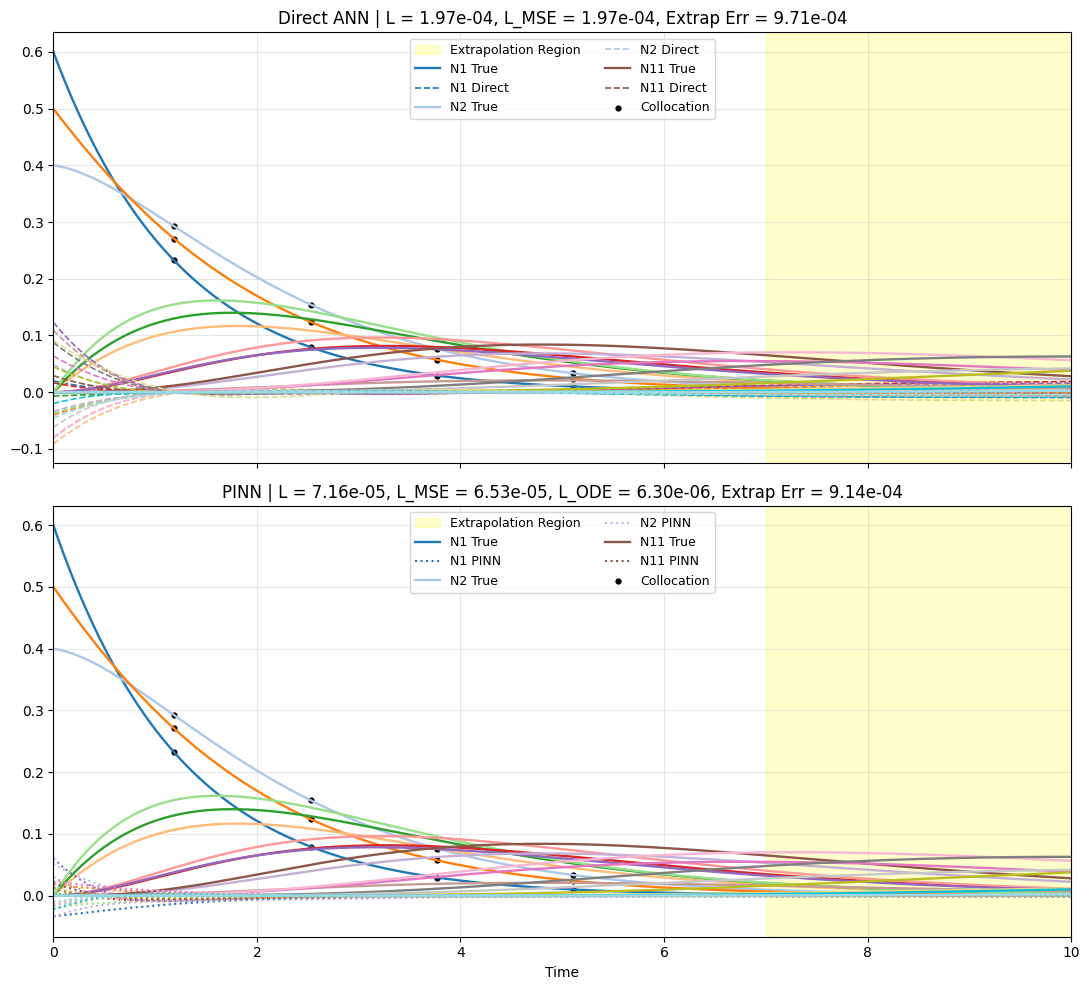

In [25]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# ----- choose a distinct colormap for up to 20 series -----
cmap = get_cmap('tab20')

# Which few isotopes to label explicitly (others are unlabeled to avoid legend clutter)
label_idxs = [0, 1, 10]  # N1, N2, N3

fig, axs = plt.subplots(2, 1, figsize=(11, 10), sharex=True)

for ax in axs:
    ax.axvspan(t_end, t_end + prediction_time, color='yellow', alpha=0.2, label='Extrapolation Region')
    ax.set_xlim([t_start, t_end + prediction_time])
    ax.grid(True, alpha=0.3)

# ---------------- Top: Direct ANN ----------------
for j in range(20):
    color = cmap(j % 20)
    lbl_true = f'N{j+1} True' if j in label_idxs else None
    lbl_pred = f'N{j+1} Direct' if j in label_idxs else None
    axs[0].plot(t_total, N_true_total[:, j], '-', lw=1.7, color=color, label=lbl_true)
    axs[0].plot(t_total, pred_direct_total[:, j], '--', lw=1.2, color=color, label=lbl_pred)

# Collocation points (first three isotopes)
axs[0].scatter(t[indices], N[indices, 0], c='k', s=12)
axs[0].scatter(t[indices], N[indices, 1], c='k', s=12)
axs[0].scatter(t[indices], N[indices, 2], c='k', s=12, label='Collocation')

axs[0].set_title(
    f"Direct ANN | L = {L_direct_total:.2e}, L_MSE = {L_direct_mse:.2e}, Extrap Err = {error_direct:.2e}"
)
axs[0].legend(ncol=2, fontsize=9, frameon=True)

# ---------------- Bottom: PINN ----------------
for j in range(20):
    color = cmap(j % 20)
    lbl_true = f'N{j+1} True' if j in label_idxs else None
    lbl_pred = f'N{j+1} PINN' if j in label_idxs else None
    axs[1].plot(t_total, N_true_total[:, j], '-', lw=1.7, color=color, label=lbl_true)
    axs[1].plot(t_total, pred_pinn_total[:, j],  ':', lw=1.5, color=color, label=lbl_pred)

# Collocation points (first three isotopes)
axs[1].scatter(t[indices], N[indices, 0], c='k', s=12)
axs[1].scatter(t[indices], N[indices, 1], c='k', s=12)
axs[1].scatter(t[indices], N[indices, 2], c='k', s=12, label='Collocation')

axs[1].set_title(
    f"PINN | L = {L_pinn_total:.2e}, L_MSE = {L_pinn_mse:.2e}, L_ODE = {L_pinn_ode:.2e}, Extrap Err = {error_pinn:.2e}"
)
axs[1].legend(ncol=2, fontsize=9, frameon=True)

plt.xlabel("Time")
plt.tight_layout()
plt.savefig('Radioactive-decay_PINN_20.png', dpi=300)
plt.show()